  0%|          | 0/1 [00:00<?, ?it/s]

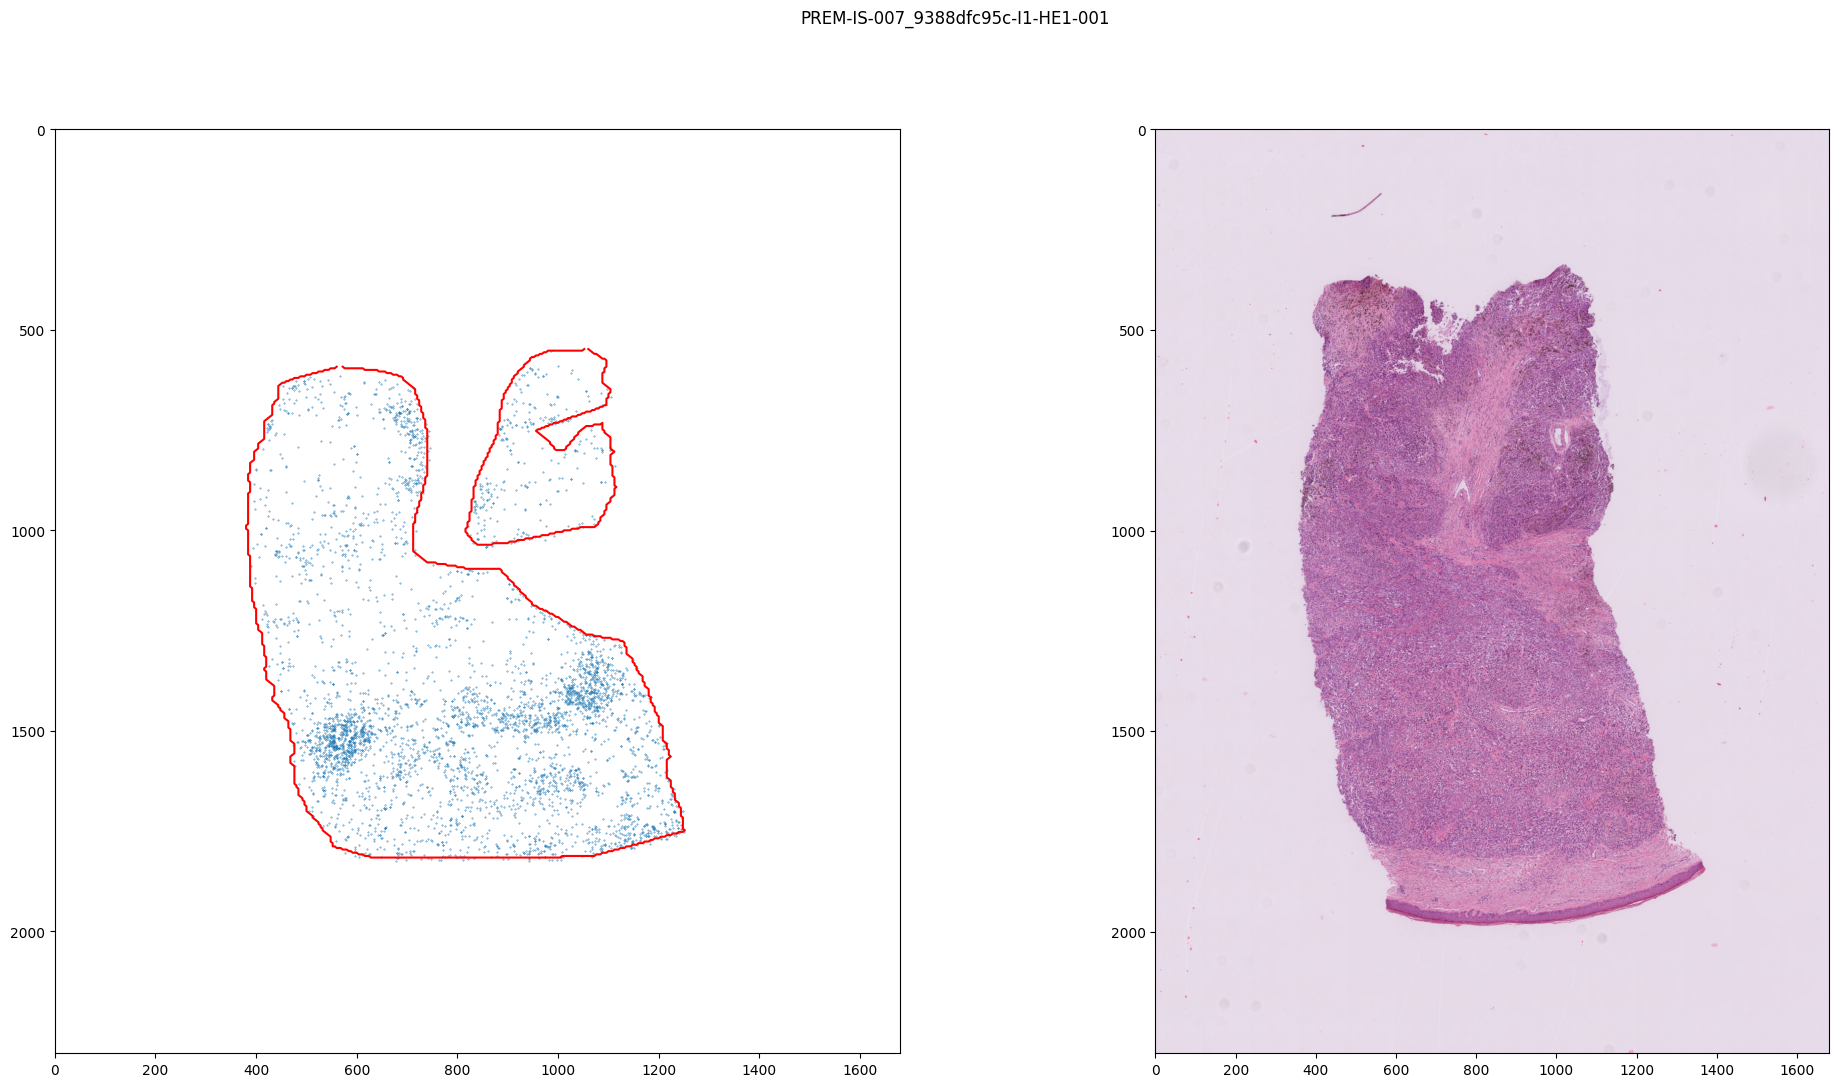

In [24]:
import cv2
import json
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from openslide import OpenSlide
from tqdm.notebook import tqdm
%matplotlib inline


r = Path('/mnt/hpc/pathology/annotations/isala/core')
output_dir = Path('/mnt/hpc/pathology/hovernet_output/isala/core')
roi_dir = r
slide_r = Path('/mnt/hpc/pathology/metastasis/isala')

df = pd.DataFrame(columns=['tils_per_area'])

for file in tqdm(sorted(list(r.iterdir()))[3:4]):
# for file in [r / 'PREM-IS-002_b7fb67d9a5 I2 HE1 - 2022-03-24 19.52.31.json']:
    # print(file.stem)


    # load hovernet output file
    
    try:
        with open(output_dir / (file.stem + '.json'), 'r') as f:
            annotations = json.load(f)
    except Exception as e:
        print(e)
        continue
        
        
    # extract centroids of all TILs
    centroids = []  
    for annotation in annotations:
        if annotation['properties']['classification']['name'] == 'inflam':
            centroid = np.array(annotation['geometry']['coordinates']).mean(axis=-2)[0]
            centroids.append(centroid)

    xx, yy = np.stack(centroids)[:,0], np.stack(centroids)[:,1]

    # load manual roi annotation
    # roi_dir = Path('/home/rens/hpc/PREMIUM histopathology/data_annotations/isala/annotations')
    
    roi_file = roi_dir / (file.stem + '.xml')

    with open(roi_file, 'r') as f:
        xml_file = ET.parse(f)

    # extract all rois
    rois = []
    for annotation in xml_file.getroot()[0]:
        roi = []
        for coordinate in annotation[0]:
            roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
        rois.append(np.array(roi).astype(float).astype(int))

    # load slide image
    
    slide = OpenSlide(str(slide_r / (file.stem + '.ndpi')))

    img = np.array(slide.read_region((0,0), 4, slide.level_dimensions[4]).convert('RGB'))
    factor = slide.level_dimensions[0][0] / slide.level_dimensions[4][0]

    # plot side by side
    fig, ax = plt.subplots(1,2, figsize=(24,12))
    fig.suptitle(file.stem)
    for roi in rois:
        ax[0].plot(roi[:,0]/factor, roi[:,1]/factor, c='r')
    ax[0].scatter(xx/factor,yy/factor, alpha=1, s=0.1)
    ax[0].set_xlim(0, slide.level_dimensions[4][0])
    ax[0].set_ylim(slide.level_dimensions[4][1], 0)
    ax[1].imshow(img)
    fig.show()
    break
    # area = np.zeros((slide.level_dimensions[0][1],slide.level_dimensions[0][0]))
    # cv2.fillPoly(area, rois, 1)
    # total_area = area.sum() * float(slide.properties['openslide.mpp-x']) * float(slide.properties['openslide.mpp-y']) 
    # # print(len(xx) / total_area)

    # df.loc[file.stem] = len(xx) / total_area

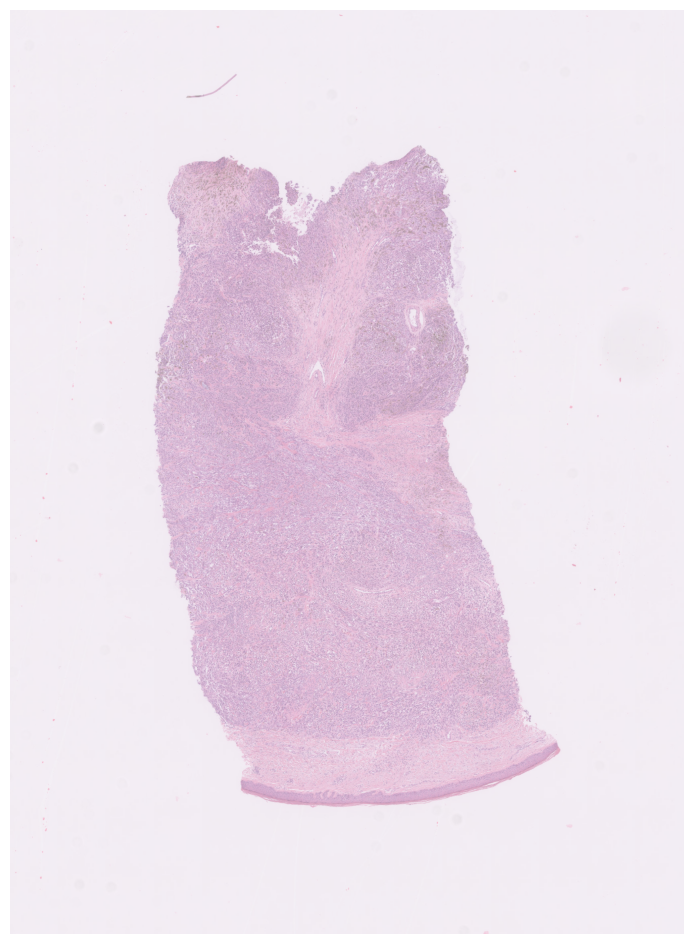

In [25]:
fig, ax = plt.subplots(1,1, figsize=(24,12))

margin = int((img.shape[1] - img.shape[0]) / 2)
cropped_img = img
ax.imshow(cropped_img, alpha=0.5)
ax.set_axis_off()
# for roi in rois:
#     ax.plot((roi[:,0]/factor).tolist() + [roi[0,0]/factor], (roi[:,1]/factor).tolist() + [roi[0,1]/factor], c='r')
# ax.scatter(xx/factor,yy/factor, alpha=1, s=0.1)
fig.show()

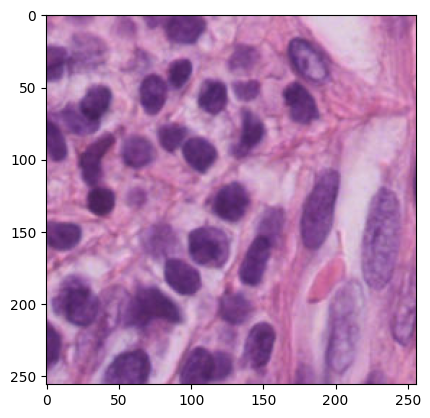

In [26]:
focus_idx = np.argmin(abs(xx - 9000) + abs(yy - 24000))
x = xx[focus_idx]
y = yy[focus_idx]

size = 256
origin = np.array([int(x - size/2), int(y-size/2)])

img = slide.read_region(
    origin,
    level=0,
    size=(size, size)
)
plt.imshow(img)
plt.show()

In [27]:
til_annotations = [a for a in annotations if a['properties']['classification']['name'] == 'inflam']

annotation = np.array(til_annotations[focus_idx]['geometry']['coordinates'][0]) - origin

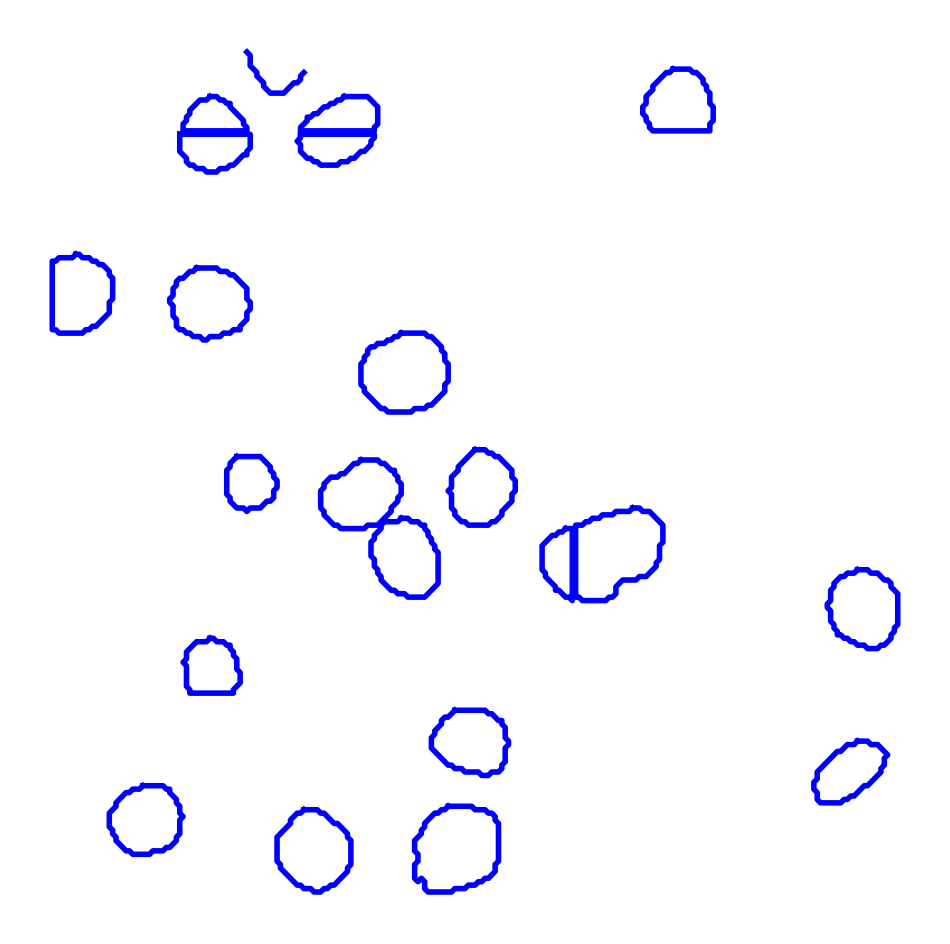

In [33]:
focus_idx = np.argmin(abs(xx - 9000) + abs(yy - 24000)) +25
x = xx[focus_idx]
y = yy[focus_idx]

size = 256
origin = np.array([int(x - size/2), int(y-size/2)])

img = slide.read_region(
    origin,
    level=0,
    size=(size, size)
)

in_frame_annotations = []
for annotation in til_annotations:
    coordinates = np.array(annotation['geometry']['coordinates'][0])
    in_frame_coordinates = [
        c for c in coordinates if
        origin[0] < c[0] < origin[0]+size and
        origin[1] < c[1] < origin[1]+size
    ]
    if in_frame_coordinates:
        in_frame_annotations.append(in_frame_coordinates)

plt.figure(figsize=(12,12))
# plt.imshow(img)
# plt.plot(annotation[:,0], annotation[:,1], c='b')
for annotation in in_frame_annotations:
    plt.plot(np.array(annotation - origin)[:,0], np.array(annotation - origin)[:,1], c='b', lw=4)
plt.gca().invert_yaxis()

plt.axis('off')
plt.show()

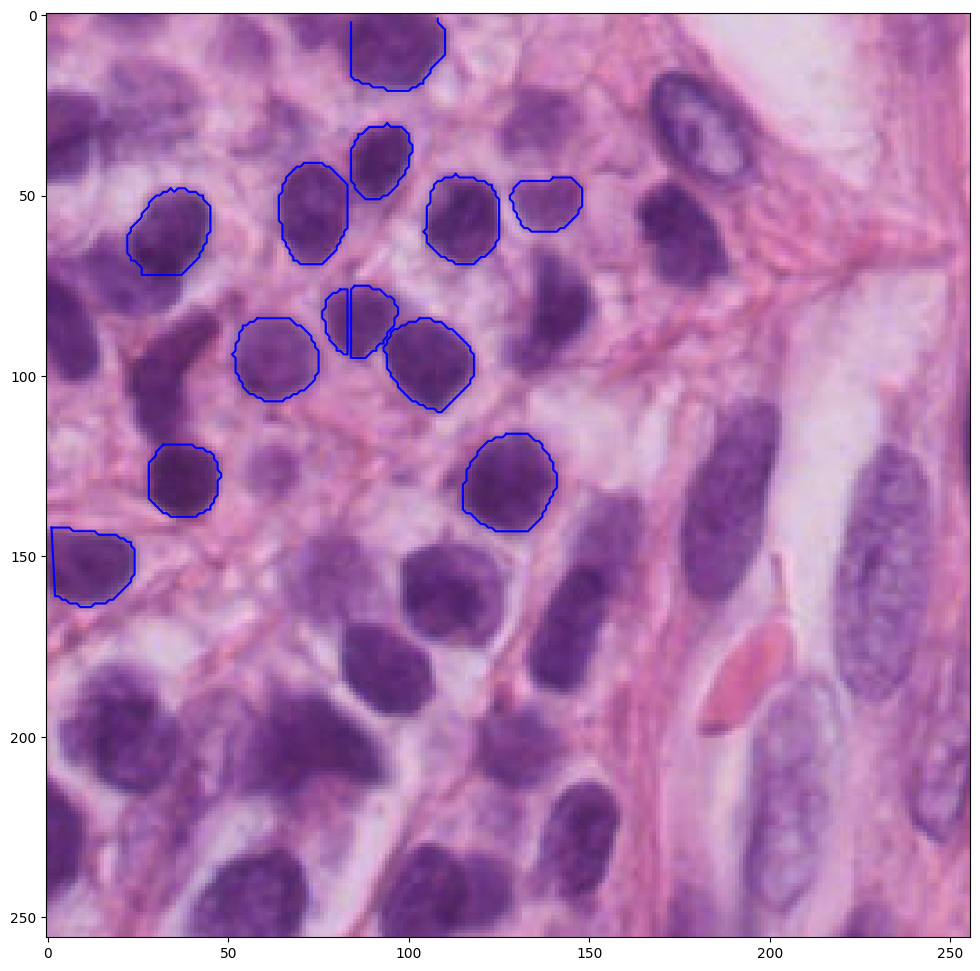

TypeError: mannwhitneyu() missing 1 required positional argument: 'y'

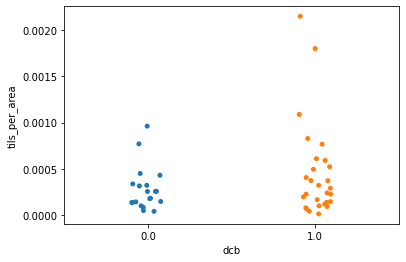

In [32]:
import seaborn as sn
from scipy.stats import mannwhitneyu

df['dcb'] = dcb

sn.stripplot(data=df.dropna(subset=['dcb']), x='dcb', y='tils_per_area')



In [33]:
print(mannwhitneyu(df[df.dcb == 0].tils_per_area, df[df.dcb == 1].tils_per_area))

MannwhitneyuResult(statistic=240.0, pvalue=0.40878724164350344)


In [10]:
import pandas as pd

manual  = pd.read_csv('/mnt/c/Users/user/Downloads/PREMIUM_TILS_Isala_METASTASIS_22_12_12_11.csv', sep='\t')
clark = manual[manual.Question == 'Clark score'].groupby('Image Name').Answer.first()
mia = manual[manual.Question == 'MIA score'].groupby('Image Name').Answer.first()
salgado = manual[manual.Question == "Salgado 'stromal'"].groupby('Image Name').Answer.first()

In [16]:
clark = clark.to_frame().rename(columns={'Answer':'clark'})
mia = mia.to_frame().rename(columns={'Answer':'mia'})
salgado = salgado.to_frame().rename(columns={'Answer':'salgado'})
manual = clark.join(mia).join(salgado)

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [28]:
pd.crosstab(manual.clark, manual.salgado)

salgado,0%,10%,15%,20%,40%,45%,5%,50%,70%,75%,80%,90%,95%,NA -> geisoleerde tumorcellen
clark,,,,,,,,,,,,,,
Absent A - no lymphocytes,37,0,0,1,0,0,0,0,0,0,0,0,0,0
"Absent B - none in tumor, but lymphocytes around",2,0,0,0,0,0,3,0,0,0,0,0,0,0
Brisk diffuse,1,0,0,0,0,1,0,3,2,1,4,2,1,0
Brisk peripheral,0,0,0,0,1,0,0,0,0,0,0,0,0,0
NA -> geisoleerde tumorcellen,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Non-brisk (localized),0,3,0,1,0,0,2,0,1,0,0,0,0,0
Non-brisk (scattered),0,5,1,4,2,0,4,0,0,0,0,0,0,0


In [21]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 3.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.
